# Cellular Potts Model (CPM)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random
import imageio
from IPython.display import HTML
import os
import base64

In [27]:
def create_and_display_gif(image_list, filename='cpm_simulation.gif', duration=0.5):
    """
    Create a GIF from a list of images, add a timestamp to each frame, display it in the notebook on repeat.
    Parameters:
    image_list (list of numpy arrays): Each numpy array represents the grid state at a step.
    filename (str): The name of the GIF file to save.
    duration (float): The display duration of each frame in the GIF.
    """
    # Create figure and axes outside the loop
    fig, ax = plt.subplots(figsize=(6, 6))
    frames = []

    for idx, image in enumerate(image_list):
        ax.clear()
        ax.imshow(image, cmap='tab20', interpolation='nearest')
        ax.axis('off')
        # Add a timestamp in the top right corner
        ax.text(0.95, 0.05, f'Time = {idx}', color='white', ha='right', va='top', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        
        # Convert the plot to an image array
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        frames.append(image)
    
    plt.close(fig)  # Close the figure after all frames are captured

    # Write frames to a GIF with loop=0 for infinite loop
    with imageio.get_writer(filename, mode='I', duration=duration, loop=0) as writer:
        for frame in frames:
            writer.append_data(frame)

    # Optionally, display the GIF in the notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="CPM Simulation" style="max-width:100%;"/>'))


def initialize_grid(size, num_cells, target_volumes):
    """
    Initialize the grid with cells placed more coherently.
    
    Parameters:
    size (int): The size of the grid (width and height).
    num_cells (int): The number of cells to place on the grid.
    target_volumes (list or numpy array): The target volume (number of sites) for each cell.
    
    Returns:
    numpy.ndarray: The initialized grid.
    """
    grid = np.zeros((size, size), dtype=int)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    for cell_id in range(1, num_cells + 1):
        volume = 0
        # Choose a random starting point for the cell
        x, y = np.random.randint(size), np.random.randint(size)
        cells_to_grow = [(x, y)]

        while volume < target_volumes[cell_id-1] and cells_to_grow:
            x, y = cells_to_grow.pop(0)
            if grid[x, y] == 0:  # If the site is not already occupied
                grid[x, y] = cell_id
                volume += 1
                # Add neighboring sites to the list of potential growth sites
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < size and 0 <= ny < size and grid[nx, ny] == 0:
                        cells_to_grow.append((nx, ny))
                random.shuffle(cells_to_grow)  # Randomize growth direction

    return grid


def calculate_delta_H(grid, i, j, i_prime, j_prime, J, lambda_area, target_areas, cell_areas):
    sigma_ij = grid[i, j]
    sigma_i_prime_j_prime = grid[i_prime, j_prime]
    
    # If the sites are from the same cell, no energy change
    if sigma_ij == sigma_i_prime_j_prime:
        return 0
    
    # Calculate the adhesion energy difference
    adhesion_energy_diff = J[sigma_ij, sigma_i_prime_j_prime] - J[sigma_ij, sigma_ij]
    
    # Calculate the area constraint energy difference
    area_energy_diff = 0
    if sigma_ij != 0:  # Exclude medium
        proposed_area = cell_areas[sigma_ij] - 1  # Current cell would lose a site
        area_energy_diff += lambda_area * ((proposed_area - target_areas[sigma_ij])**2 - (cell_areas[sigma_ij] - target_areas[sigma_ij])**2)
    if sigma_i_prime_j_prime != 0:  # Exclude medium
        proposed_area = cell_areas[sigma_i_prime_j_prime] + 1  # Neighboring cell would gain a site
        area_energy_diff += lambda_area * ((proposed_area - target_areas[sigma_i_prime_j_prime])**2 - (cell_areas[sigma_i_prime_j_prime] - target_areas[sigma_i_prime_j_prime])**2)
    
    return adhesion_energy_diff + area_energy_diff


def metropolis_update(grid, J, lambda_area, target_areas, cell_areas, T=1.0):
    size = grid.shape[0]
    i, j = np.random.randint(size), np.random.randint(size)
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    i_prime, j_prime = random.choice(neighbors)
    
    # Ensure periodic boundary conditions
    i_prime %= size
    j_prime %= size
    
    delta_H = calculate_delta_H(grid, i, j, i_prime, j_prime, J, lambda_area, target_areas, cell_areas)
    if delta_H <= 0 or np.random.rand() < np.exp(-delta_H / T):
        # Update cell areas before changing indices
        if grid[i, j] != grid[i_prime, j_prime]:  # Ensure different cell types
            cell_areas[grid[i, j]] -= 1
            cell_areas[grid[i_prime, j_prime]] += 1
        grid[i, j] = grid[i_prime, j_prime]


def cpm_simulation(size, num_cells, J, lambda_area, target_areas, steps, T=1.0, initial_grid=None):
    if initial_grid is None:
        grid = initialize_grid(size, num_cells, target_areas)
    else:
        grid = initial_grid.copy()
        
    # Initialize cell areas
    cell_areas = np.array([np.sum(grid == cell_id) for cell_id in range(num_cells + 1)])
    
    history = [grid.copy()]  # Save initial state
    
    for step in range(steps):
        for _ in range(size*size):  # As many updates as sites in the lattice per timestep
            metropolis_update(grid, J, lambda_area, target_areas, cell_areas, T=T)
        
        # Recalculate cell areas
        cell_areas = np.array([np.sum(grid == cell_id) for cell_id in range(num_cells + 1)])

        history.append(grid.copy())  # Save state after each timestep    
    return history


In [47]:
# Example parameters
size = 50
num_cells = 10

# adhesion matrix
J = np.zeros((num_cells + 1, num_cells + 1)) + 2  # Increase cell-cell adhesion penalty
for i in range(1, num_cells + 1):
    J[i, i] = 0.5  # Minimize self-adhesion energy
J[0, :] = J[:, 0] = 1  # adhesion energy to medium

lambda_area = 1
target_areas = np.full(num_cells + 1, 25)  # Example target areas; adjust as needed

steps = 100
T = 0.8

# initialize
initial_areas = np.full(num_cells + 1, 10)  # Example target areas; adjust as needed
initial_grid = initialize_grid(size, num_cells, initial_areas)

# simulate
history = cpm_simulation(
    size, num_cells, J, lambda_area, target_areas, steps, T, initial_grid=initial_grid)

/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_48948/565273102.py:22: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')



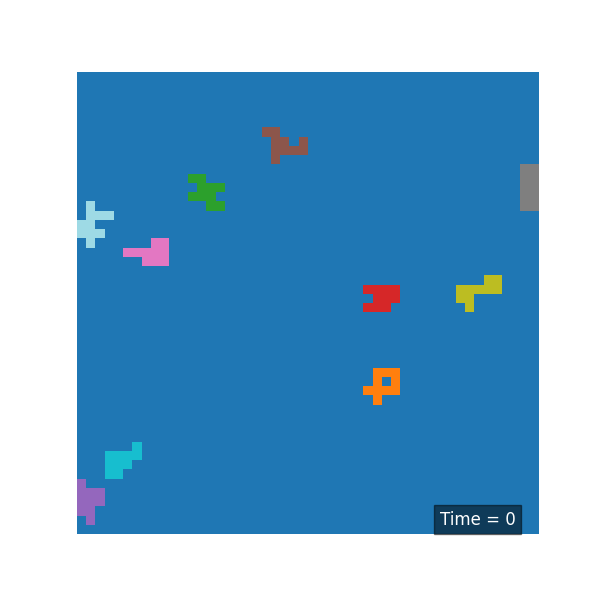

In [48]:
create_and_display_gif(history)